In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [2]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [3]:
# load questions (to be removed)

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [4]:
!ls 

1800.pickle                          prompt100.py
644sample                            prompt100gemmalocal.py
644sample-multi                      prompt100tablellama.py
README.md                            prompt_wip.py
TableLlama.2073770127.pickle         prompt_wip_sel.py
TableLlama.3729511693.pickle         runner.py
aggrodue.pickle                      select_errors_from_1800.ipynb
cohesion.ipynb                       selected_pids.644.pickle
cohesion.pickle                      selected_pids.688.pickle
delme.xlsx                           tablellama-classifier-ag.ipynb
gemma-2-2b-it.3892595837.pickle      tablellama-classifier.ipynb
gemma-2-9b-it-4bit.3246737286.pickle tablellama-high
jensension.ipynb                     tablellama-multipass.ipynb
logits-tablellama.ipynb              tablellama-plot copy.ipynb
mirror                               tablellama-plot.ipynb
older tablellama                     tablellama.preprocessed.pickle
pdf                                  tablella

In [5]:
%%time

# load processed data

import os
import pickle
from copy import deepcopy

prefix = './644sample-multi/' # runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            for pid, item in enumerate(tqdm(outlist_)):
                # explode multiruns
                for i, _ in enumerate(item["post_output_sequences"]):
                    item_ = deepcopy(item)
                    item_["post_output_sequences"] = item["post_output_sequences"][i]
                    item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                    item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                    item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 
                    item_["run"] = run + i
                    outlist.append(item_)
            run = run + i + 1 # next file

len(outlist)

TableLlama.3426140835.pickle


100%|█████████████████████████████████████████| 688/688 [04:05<00:00,  2.80it/s]


TableLlama.2944716311.pickle


100%|█████████████████████████████████████████| 688/688 [03:00<00:00,  3.81it/s]


TableLlama.3464191535.pickle


100%|█████████████████████████████████████████| 688/688 [03:14<00:00,  3.53it/s]

CPU times: user 46min 13s, sys: 24min 54s, total: 1h 11min 7s
Wall time: 10min 54s


6880

In [6]:
len(outlist_), len(outlist), outlist[-1]['run']

(688, 6880, 9)

### check output against ground truth

In [7]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], generated_text, post_output_sequences, b))

Token indices sequence length is longer than the specified maximum sequence length for this model (6471 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 53.7 s, sys: 2.3 s, total: 56 s
Wall time: 58.6 s


In [8]:
# true, hallucinated, counted
t, h, c

(4977, 36, 6880)

In [9]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [10]:
truth[truth.pid==112]

,run,pid,correct,hallucinated
164,0,112,True,False
165,1,112,False,False
166,2,112,True,False
167,3,112,True,False
2875,4,112,True,False
2876,5,112,True,False
2877,6,112,True,False
4939,7,112,True,False
4940,8,112,True,False
4941,9,112,True,False


In [11]:
truth.describe(include='all')

,run,pid,correct,hallucinated
count,6880.00000,6880.000000,6880,6880
unique,NaN,NaN,2,2
top,NaN,NaN,True,False
freq,NaN,NaN,4977,6844
mean,4.50000,901.360465,NaN,NaN
std,2.87249,519.031166,NaN,NaN
min,0.00000,9.000000,NaN,NaN
25%,2.00000,449.250000,NaN,NaN
50%,4.50000,883.000000,NaN,NaN
75%,7.00000,1366.750000,NaN,NaN


<Axes: xlabel='correct', ylabel='Count'>

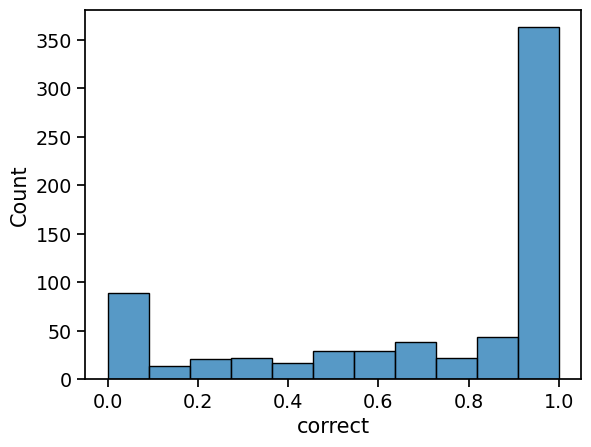

In [12]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

<Axes: xlabel='hallucinated', ylabel='Count'>

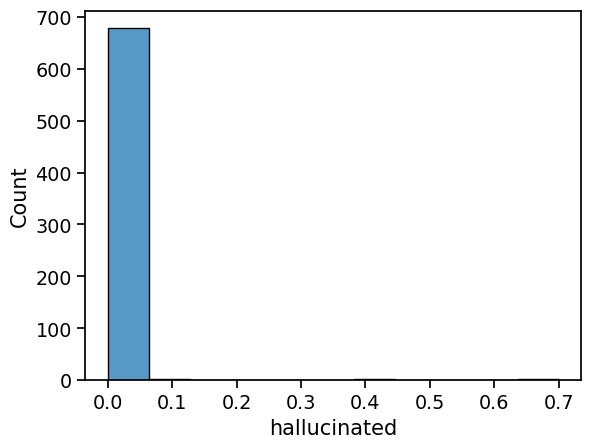

In [13]:
sns.histplot(truth.groupby('pid').hallucinated.mean())

In [14]:
truth.groupby('pid').size().value_counts()

10    688
Name: count, dtype: int64

In [15]:
truth

,run,pid,correct,hallucinated
0,0,9,False,False
1,1,9,False,False
2,2,9,False,False
3,3,9,True,False
4,0,10,False,False
...,...,...,...,...
6875,8,1794,True,False
6876,9,1794,True,False
6877,7,1797,True,False
6878,8,1797,True,False


In [16]:
accu = truth.groupby('pid').correct.mean()

In [17]:
accu[accu<1.].shape

(325,)

In [18]:
accu.value_counts()

correct
1.0    363
0.0     89
0.9     44
0.7     38
0.5     29
0.6     29
0.8     22
0.3     22
0.2     21
0.4     17
0.1     14
Name: count, dtype: int64

In [19]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

In [20]:
answers[answers.pid==112]

,run,pid,answer,answer_seq,right_answer
164,0,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
165,1,112,Asolo [DESC] Italian comune [TYPE] comune of I...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
166,2,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
167,3,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
2875,4,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
2876,5,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
2877,6,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
4939,7,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
4940,8,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
4941,9,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...


### sequence components alignment
### (build "segments" for each sequence)

In [21]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [22]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 1min 59s, sys: 918 ms, total: 2min
Wall time: 1min 59s


In [23]:
# check the checks (must be False)
'False' in checks

False

In [24]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [25]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [26]:
segments['length'] = segments.end - segments.start

In [27]:
segments

,run,pid,start,end,segment,seq,length
0,0,9,0,40,preamble,0,40
1,0,9,41,135,instruction,1,94
2,0,9,136,5117,input,2,4981
3,0,9,5118,6405,question,3,1287
4,0,9,6406,6470,postilla,4,64
...,...,...,...,...,...,...,...
41275,9,1797,41,135,instruction,1,94
41276,9,1797,136,859,input,2,723
41277,9,1797,860,5398,question,3,4538
41278,9,1797,5399,5463,postilla,4,64


### segment description

In [28]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.012028,0.012028
2,instruction,1,94.000000,0.000000,94,94,0.028266,0.040294
1,input,2,1825.149709,1572.546861,141,6987,0.548823,0.589117
5,question,3,1277.675872,399.390706,79,4543,0.384198,0.973315
3,postilla,4,64.000000,0.000000,64,64,0.019245,0.992560
0,generated,5,24.742878,5.820848,13,56,0.007440,1.000000


<Axes: xlabel='length', ylabel='Count'>

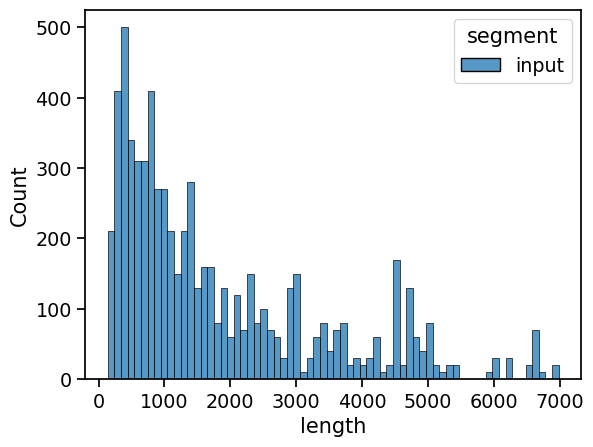

In [29]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='length'>

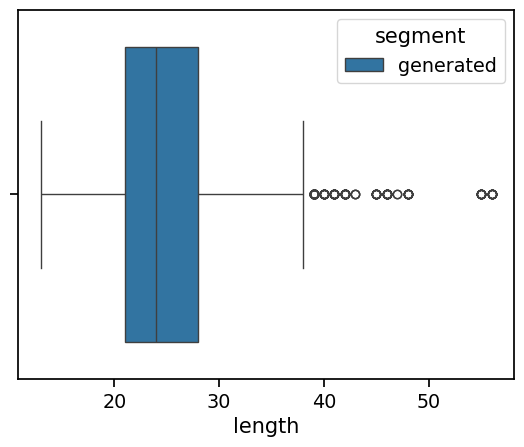

In [30]:
sns.boxplot(segments[segments.segment=='generated'], x='length', hue='segment')

<Axes: xlabel='segment', ylabel='length'>

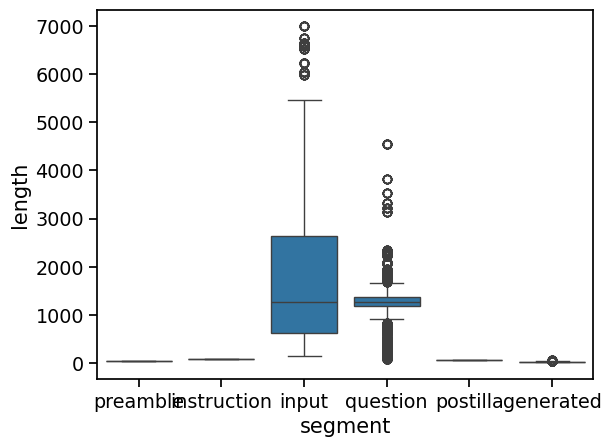

In [31]:
sns.boxplot(segments, y='length', x='segment')

In [32]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### collect observables

In [33]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

CPU times: user 17.5 s, sys: 734 ms, total: 18.2 s
Wall time: 17.9 s


In [34]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

CPU times: user 12.3 s, sys: 1.52 s, total: 13.8 s
Wall time: 13.9 s


In [35]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [36]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,68800.000000,68800.000000,68800.000000,68800.000000,68800.000000,68800.000000
mean,4.500000,901.360465,3300.325581,6.872820,0.594069,0.842458
std,2.872302,518.997217,1603.584821,32.147433,0.930689,0.238383
min,0.000000,9.000000,488.000000,1.000000,0.000000,0.086365
25%,2.000000,449.250000,2078.750000,1.000000,0.000113,0.714233
50%,4.500000,883.000000,2775.500000,1.000000,0.016675,0.998047
75%,7.000000,1366.750000,4206.500000,2.000000,0.898675,1.000000
max,9.000000,1797.000000,8230.000000,946.000000,5.685452,1.000000


In [37]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,68800.000000,68800.000000,68800.000000,68800.000000,6.880000e+04,68800.000000
mean,4.500000,901.360465,3310.325581,1.060858,4.363220e-02,0.983640
std,2.872302,518.997217,1603.584821,0.339594,1.715807e-01,0.073250
min,0.000000,9.000000,498.000000,1.000000,6.144181e-10,0.163075
25%,2.000000,449.250000,2088.750000,1.000000,5.493006e-07,0.999935
50%,4.500000,883.000000,2785.500000,1.000000,8.774491e-06,1.000000
75%,7.000000,1366.750000,4216.500000,1.000000,7.501378e-04,1.000000
max,9.000000,1797.000000,8240.000000,10.000000,2.319561e+00,1.000000


In [38]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 9.84 s, sys: 6.8 s, total: 16.6 s
Wall time: 19.6 s


In [39]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...
137527121,9,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23
137527127,9,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23
137527133,9,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23
137527139,9,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23


In [40]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [41]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [42]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [43]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [44]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [45]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [46]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [47]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.28828123

In [48]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.043671735

In [49]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00060835824

In [50]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

5.799174e-06

In [51]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [52]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   2.6G Mar 15 09:54 preprocessed.pickle


## Load preprocessed

In [53]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [54]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137527121,9,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
137527127,9,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
137527133,9,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
137527139,9,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [55]:
m.area.unique()

array(['prompt', 'generated'], dtype=object)

In [56]:
mm = m.copy()

### single run plots

In [57]:
m = mm[mm.run==0].copy()

In [58]:
NUM_BINS = 100

100


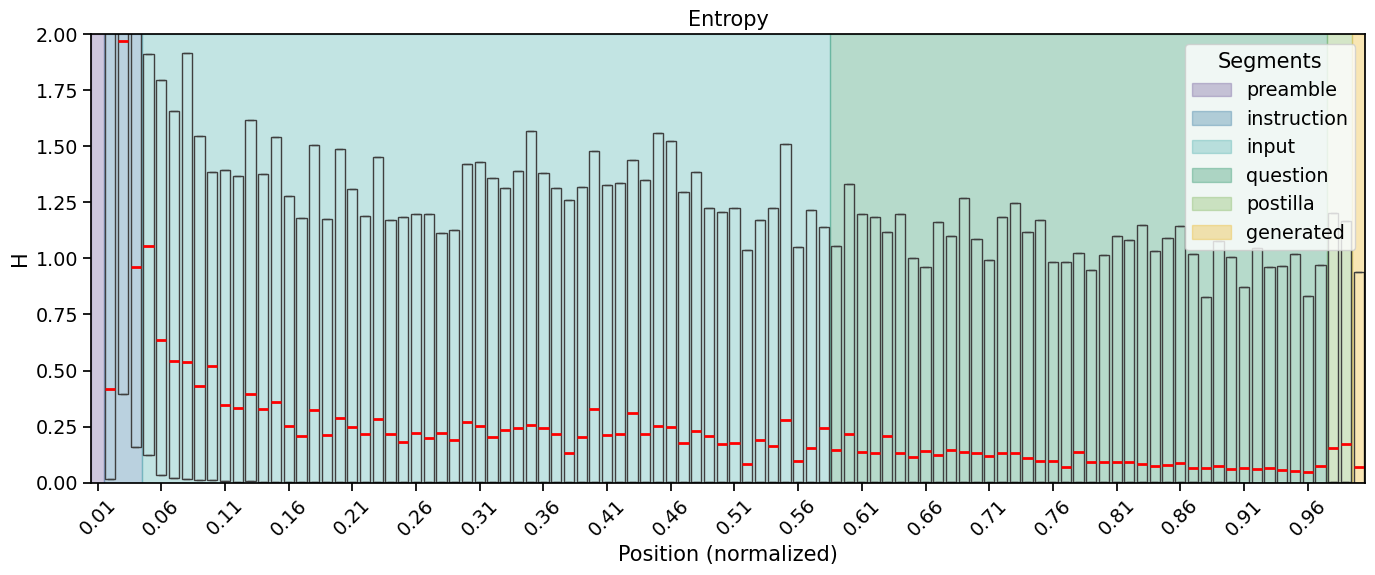

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [60]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


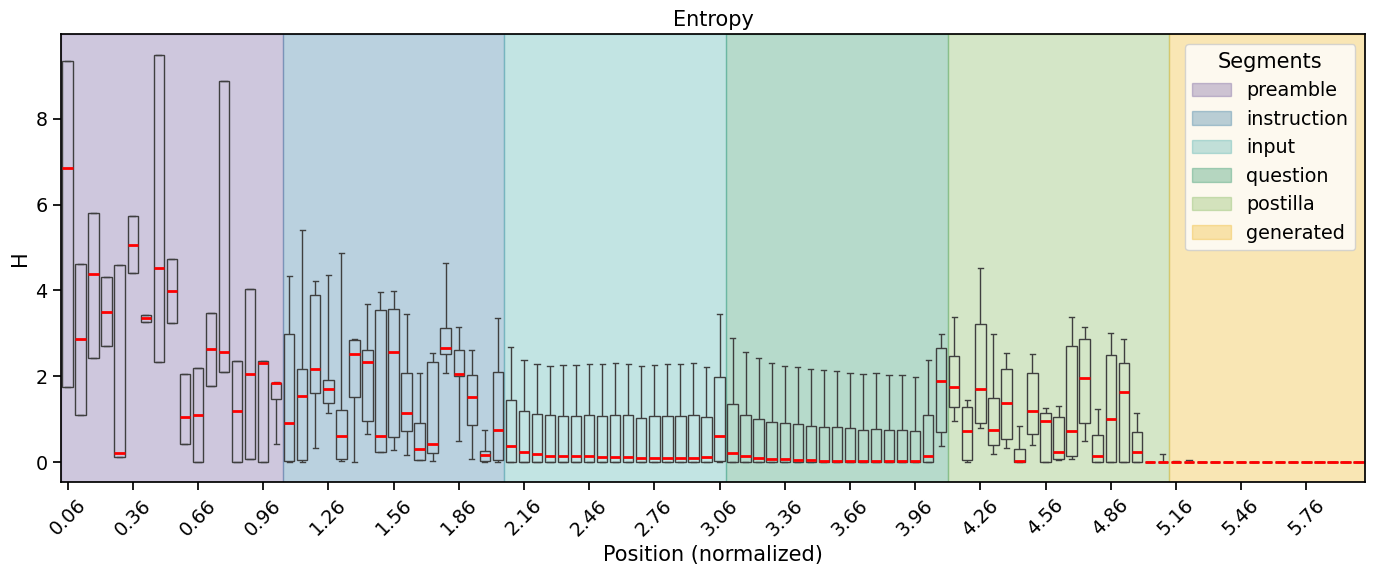

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [62]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

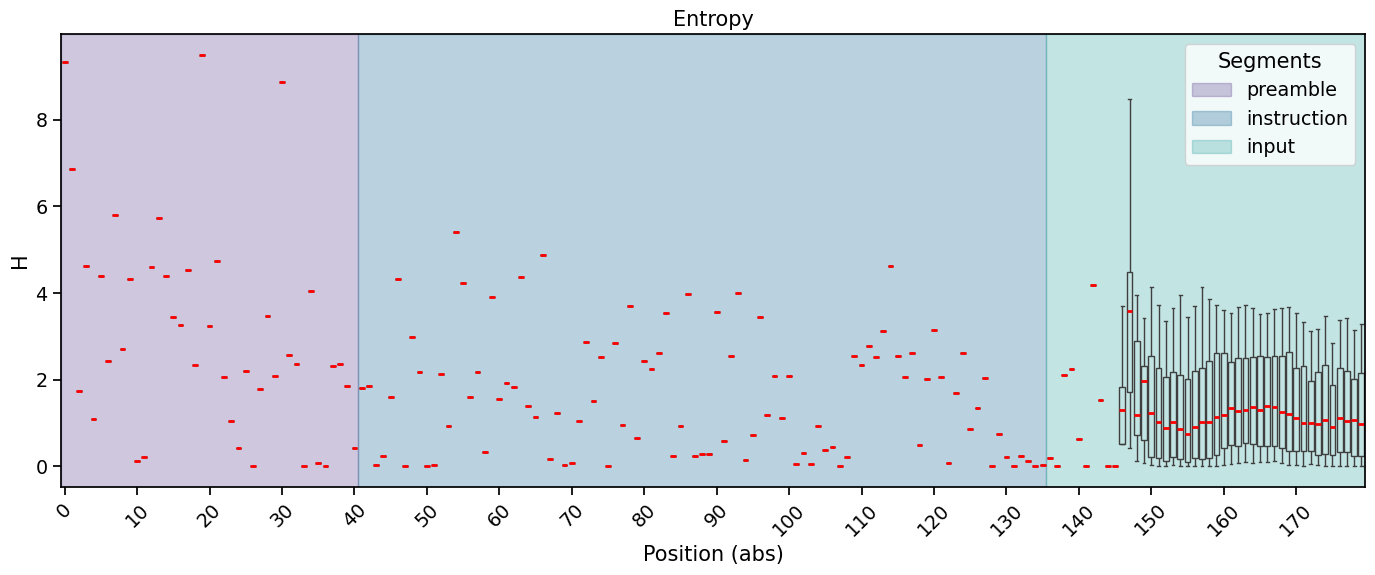

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [64]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [65]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

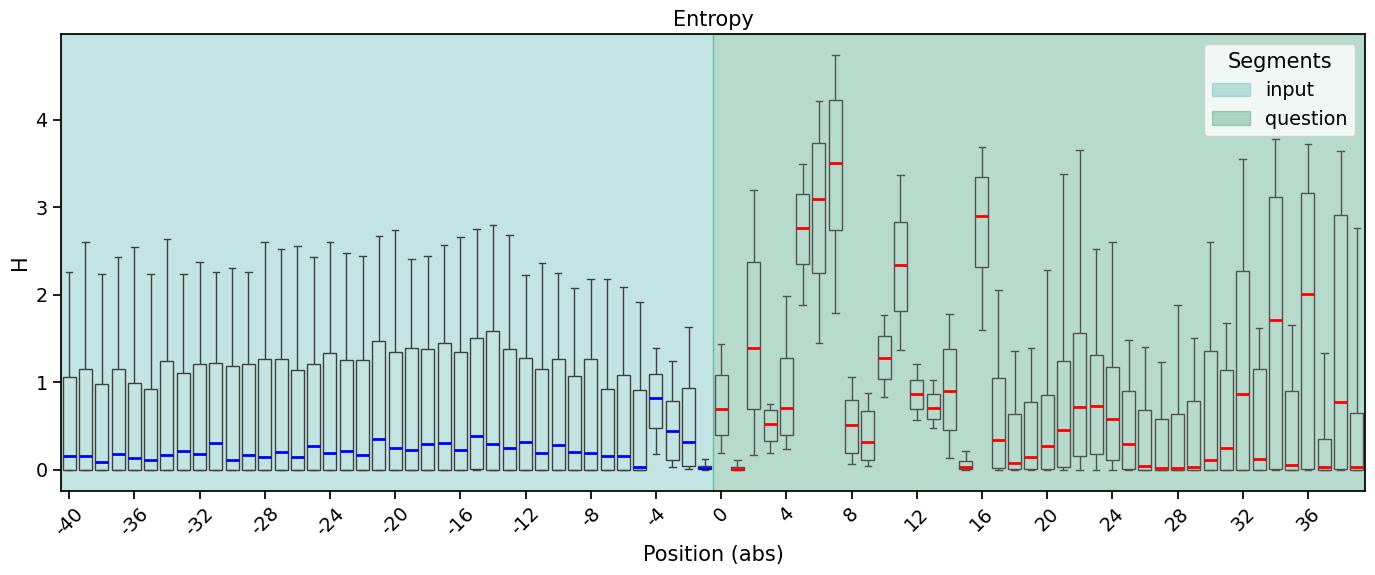

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [67]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

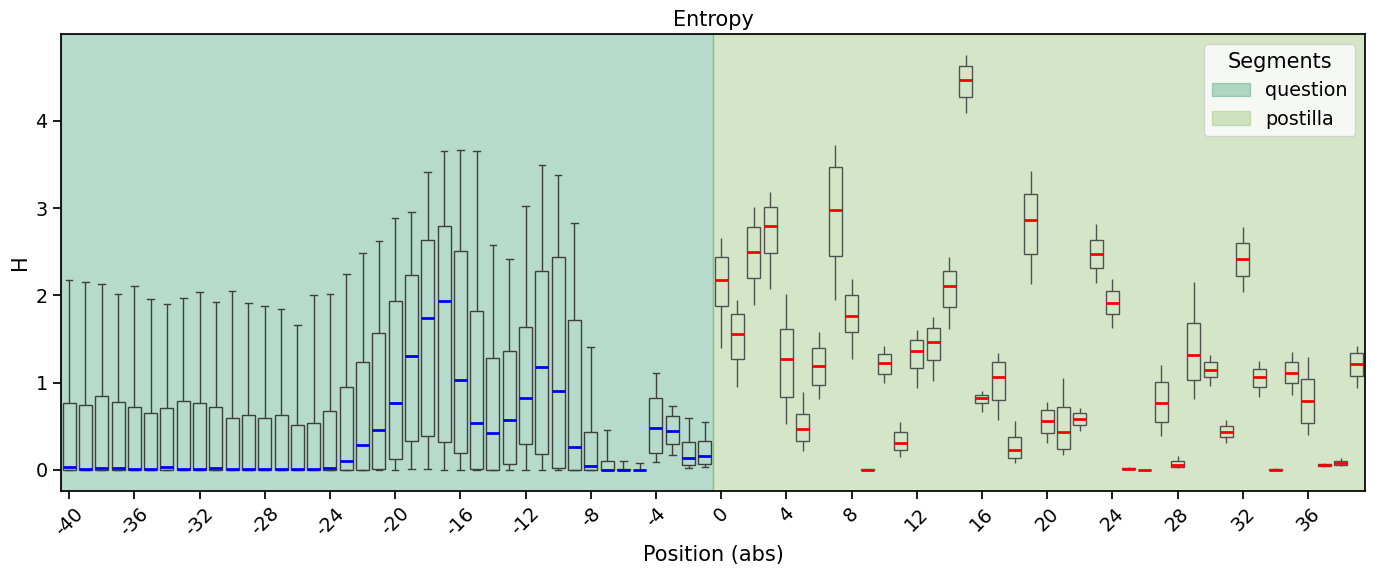

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [69]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

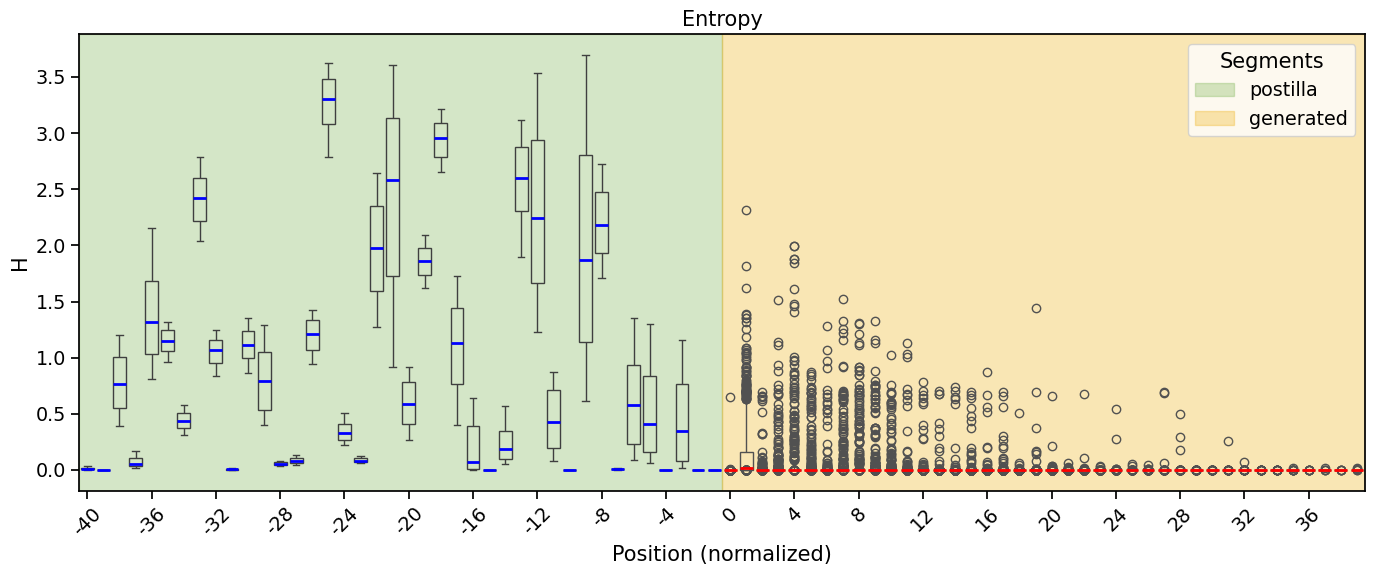

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [71]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_73756/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_73756/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


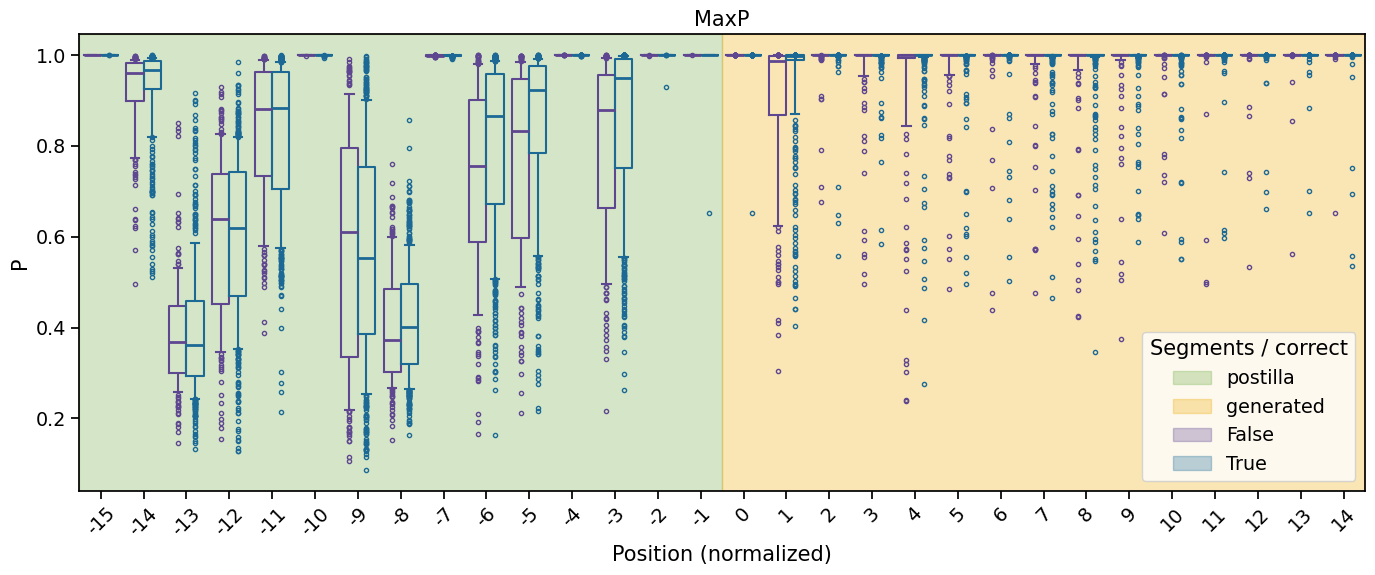

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [73]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_73756/2499406647.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_73756/2499406647.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


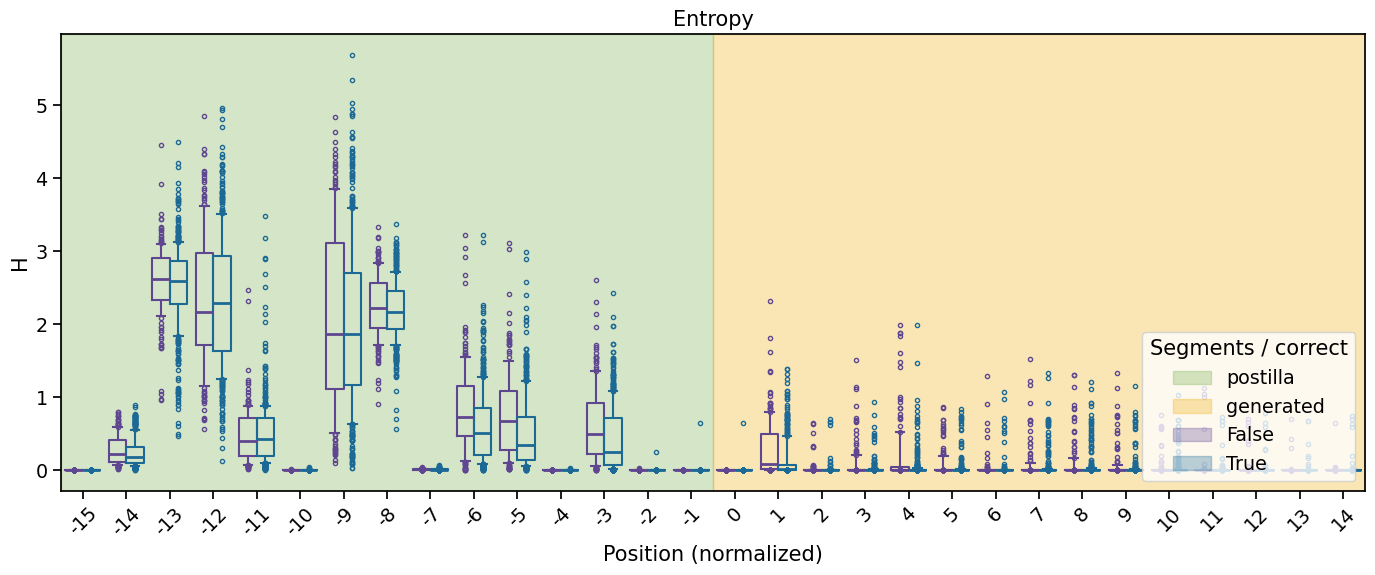

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

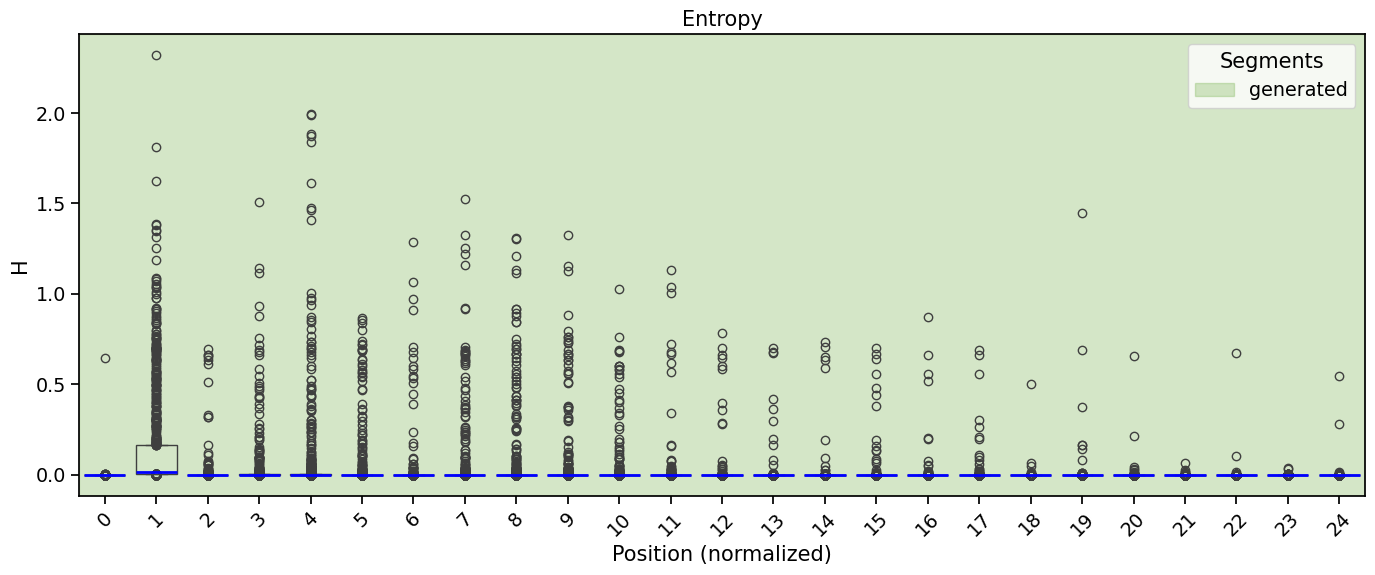

In [75]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [76]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [77]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [78]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [79]:
m[m.segment=='input'].groupby('pid').size().std()

1573.576576615972

In [80]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.9572453

In [81]:
df[df.tok_bin_idx==0].true_ent.var()

10.00165

100


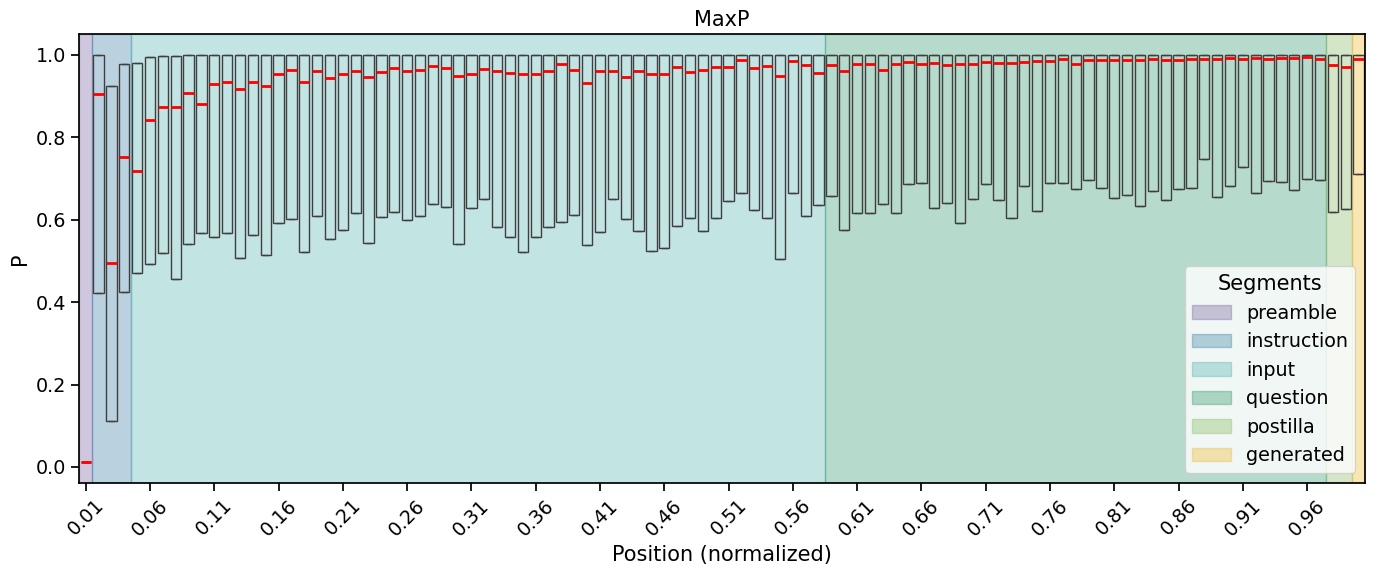

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

100


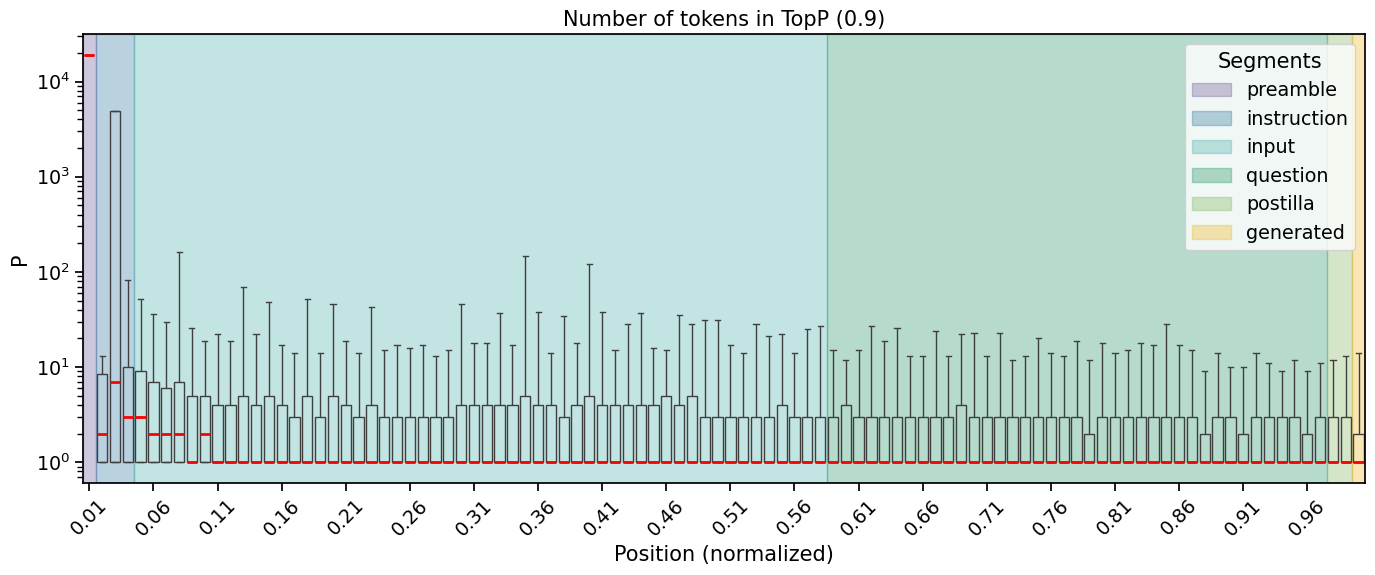

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [84]:
mm[mm.area=='prompt'].true_ent.describe()

count    2.274408e+07
mean     7.961508e-01
std      1.202175e+00
min      0.000000e+00
25%      1.045520e-03
50%      1.538483e-01
75%      1.183405e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [85]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137527121,9,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
137527127,9,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
137527133,9,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
137527139,9,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [86]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [87]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [88]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [89]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

23.926033

In [90]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

120.22222222222223

In [91]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

3.940242257023242

In [92]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [93]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [94]:
mv = mm[mm.pid.isin(variators)]

In [95]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([   9,   12,   14,   17,   18,   23,   39,   41,   45,   53,   60,
         63,   89,   94,   99,  109,  112,  118,  119,  123,  125,  128,
        130,  138,  143,  164,  177,  181,  182,  187,  188,  190,  195,
        208,  209,  216,  218,  221,  224,  229,  238,  265,  266,  270,
        278,  279,  288,  292,  297,  298,  300,  305,  308,  310,  311,
        312,  318,  320,  328,  329,  342,  344,  352,  359,  367,  368,
        382,  385,  388,  391,  394,  398,  408,  421,  446,  453,  457,
        458,  474,  476,  482,  484,  486,  492,  496,  507,  511,  516,
        518,  521,  533,  534,  561,  565,  583,  584,  607,  613,  614,
        621,  627,  629,  632,  633,  639,  658,  662,  682,  698,  699,
        700,  708,  711,  715,  717,  718,  719,  723,  725,  728,  731,
        741,  743,  753,  757,  758,  766,  768,  771,  777,  782,  785,
        790,  805,  810,  823,  836,  837,  839,  847,  854,  858,  864,
        875,  879,  880,  884,  886,  890,  892,  9

In [96]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [97]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([   9,   10,   12,   14,   17,   18,   23,   41,   45,   53,   63,
         74,   79,   85,   86,   89,   94,   99,  109,  112,  118,  119,
        123,  125,  128,  130,  134,  137,  138,  139,  143,  149,  164,
        177,  181,  182,  188,  190,  195,  200,  208,  209,  216,  218,
        221,  224,  229,  238,  265,  266,  269,  270,  278,  288,  292,
        297,  298,  300,  302,  308,  310,  311,  312,  318,  320,  330,
        342,  344,  352,  359,  364,  367,  368,  374,  382,  385,  388,
        391,  394,  398,  403,  404,  408,  409,  421,  440,  442,  446,
        453,  454,  457,  458,  474,  476,  482,  484,  486,  492,  493,
        496,  507,  511,  516,  518,  521,  533,  534,  558,  561,  583,
        584,  590,  592,  607,  614,  621,  628,  629,  632,  633,  639,
        658,  662,  682,  698,  699,  700,  708,  711,  715,  717,  718,
        719,  723,  725,  728,  731,  741,  743,  753,  757,  758,  766,
        768,  771,  777,  782,  785,  788,  790,  7

In [98]:
set(v1) - set(v2)

{39,
 60,
 187,
 279,
 305,
 328,
 329,
 565,
 613,
 627,
 836,
 890,
 983,
 1004,
 1104,
 1107,
 1113,
 1210,
 1288,
 1331,
 1440,
 1548,
 1605,
 1614,
 1615,
 1681,
 1687,
 1750,
 1770,
 1797}

In [99]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,9,0.5
2,12,0.4
3,14,0.6
4,17,0.6
5,18,0.5
...,...,...
677,1770,1.0
679,1775,0.9
680,1776,0.6
681,1781,0.9


In [100]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct


In [101]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
38831,0,9,6471,generated,1,7.224133e-06,1.000000,6471,6503,generated,5,32,0.995079,5.000000,0,-33,"(4.98, 5.04]",5.04,4.98
38837,0,9,6472,generated,1,5.841955e-02,0.992606,6471,6503,generated,5,32,0.995233,5.031250,1,-32,"(4.98, 5.04]",5.04,4.98
38843,0,9,6473,generated,1,5.036472e-06,1.000000,6471,6503,generated,5,32,0.995387,5.062500,2,-31,"(5.04, 5.1]",5.10,5.04
38849,0,9,6474,generated,2,7.166480e-01,0.518202,6471,6503,generated,5,32,0.995541,5.093750,3,-30,"(5.04, 5.1]",5.10,5.04
38855,0,9,6475,generated,1,1.664804e-08,1.000000,6471,6503,generated,5,32,0.995694,5.125000,4,-29,"(5.1, 5.16]",5.16,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54912389,0,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5,"(5.82, 5.88]",5.88,5.82
54912395,0,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4,"(5.82, 5.88]",5.88,5.82
54912401,0,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3,"(5.88, 5.94]",5.94,5.88
54912407,0,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2,"(5.94, 6.0]",6.00,5.94


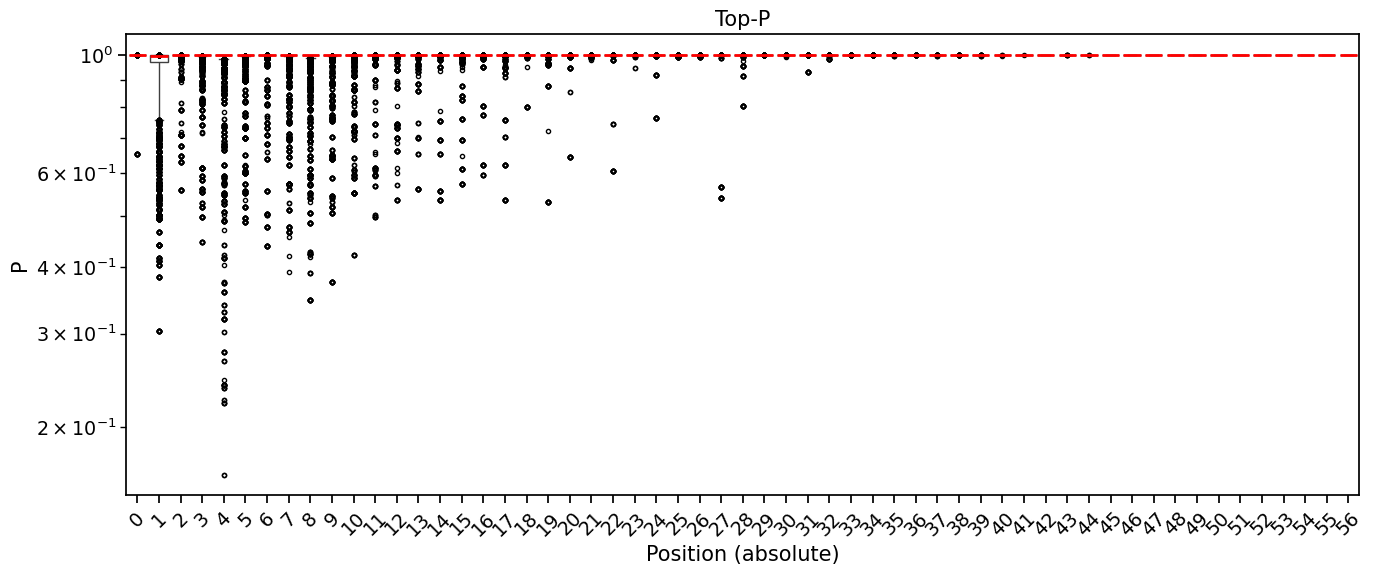

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

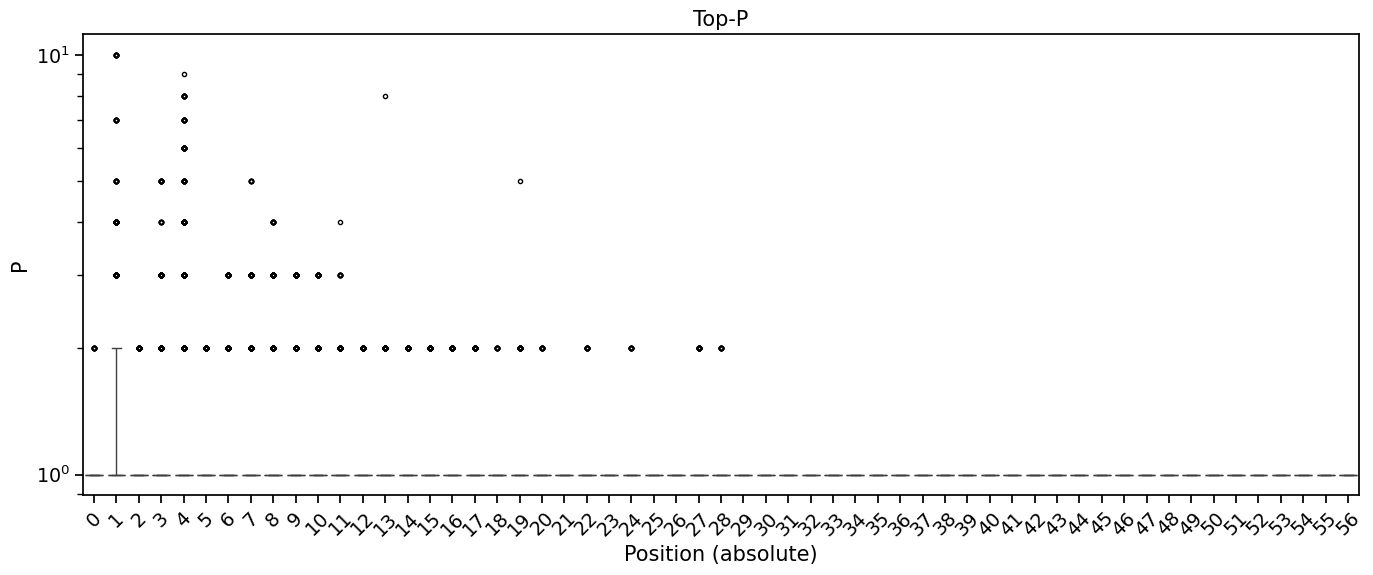

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [104]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
38831,0,9,6471,generated,1,7.224133e-06,1.000000,6471,6503,generated,5,32,0.995079,5.000000,0,-33
38837,0,9,6472,generated,1,5.841955e-02,0.992606,6471,6503,generated,5,32,0.995233,5.031250,1,-32
38843,0,9,6473,generated,1,5.036472e-06,1.000000,6471,6503,generated,5,32,0.995387,5.062500,2,-31
38849,0,9,6474,generated,2,7.166480e-01,0.518202,6471,6503,generated,5,32,0.995541,5.093750,3,-30
38855,0,9,6475,generated,1,1.664804e-08,1.000000,6471,6503,generated,5,32,0.995694,5.125000,4,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137527121,9,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
137527127,9,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
137527133,9,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
137527139,9,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


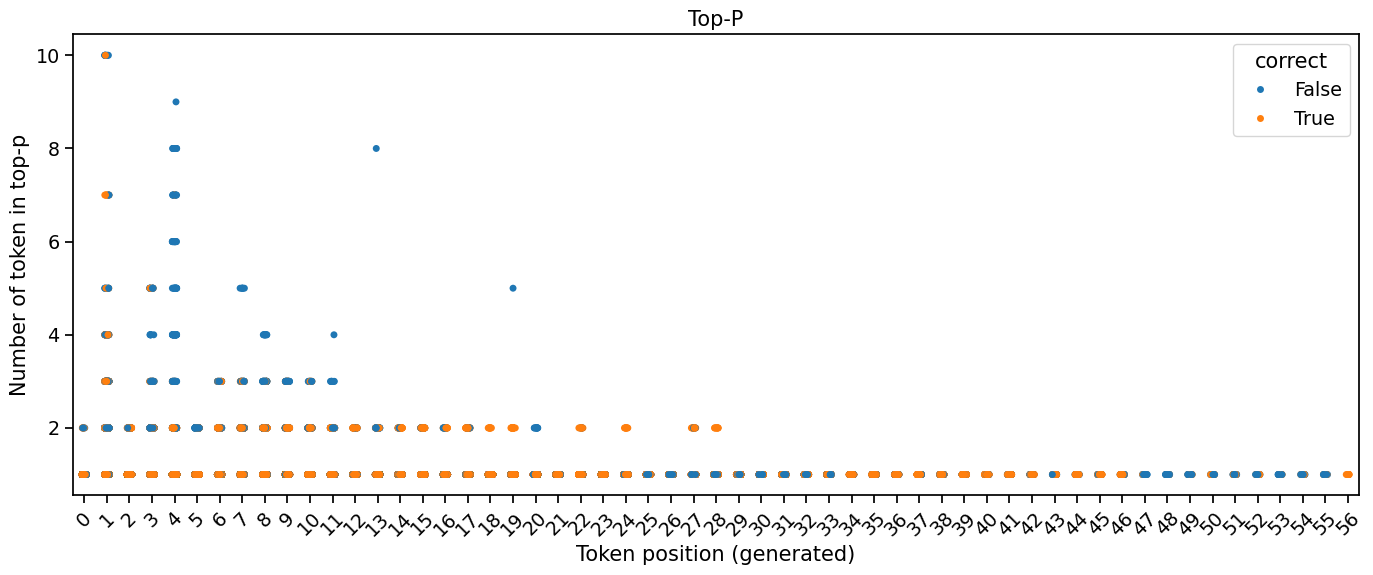

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

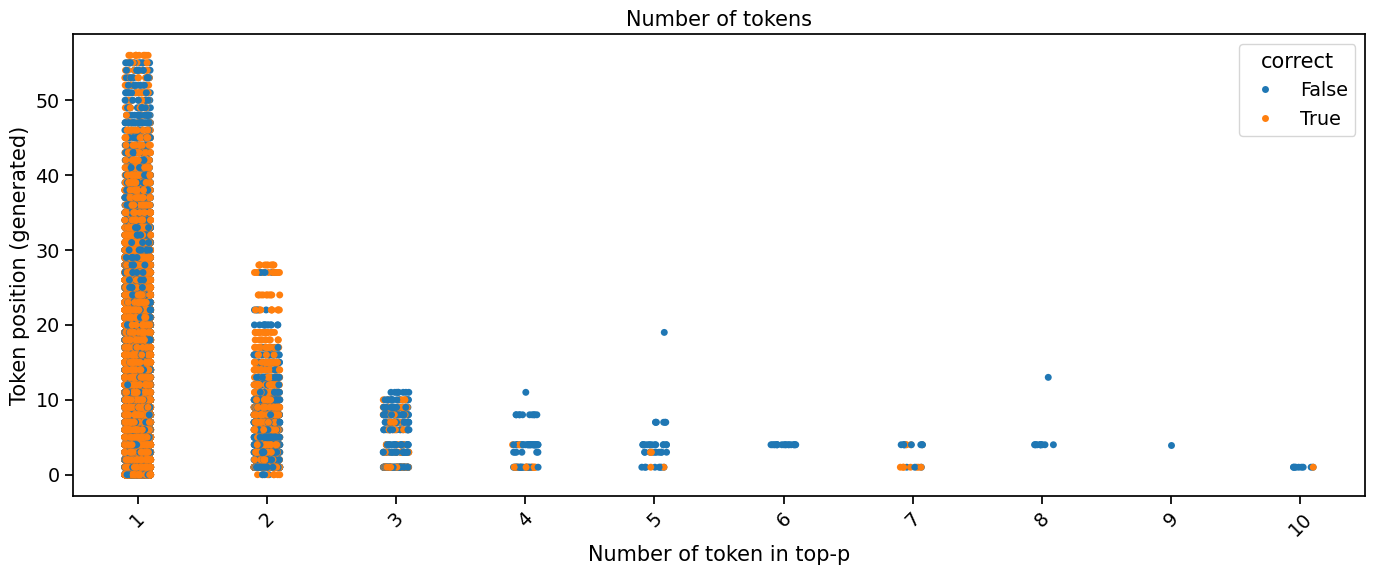

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [107]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,173247,0.724769
2,3296,0.544903
3,369,0.344173
4,92,0.250000
5,44,0.113636
6,18,0.000000
7,22,0.454545
8,12,0.000000
9,1,0.000000


In [108]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.978183
2     0.018610
3     0.002083
4     0.000519
5     0.000248
6     0.000102
7     0.000124
8     0.000068
9     0.000006
10    0.000056
Name: correct, dtype: float64

In [109]:
mm[mm.segment=='generated'].true_ent.describe()

count    1.771110e+05
mean     2.000894e-02
std      1.159025e-01
min      7.314307e-12
25%      4.174491e-07
50%      3.777819e-06
75%      6.925198e-05
max      2.319561e+00
Name: true_ent, dtype: float64

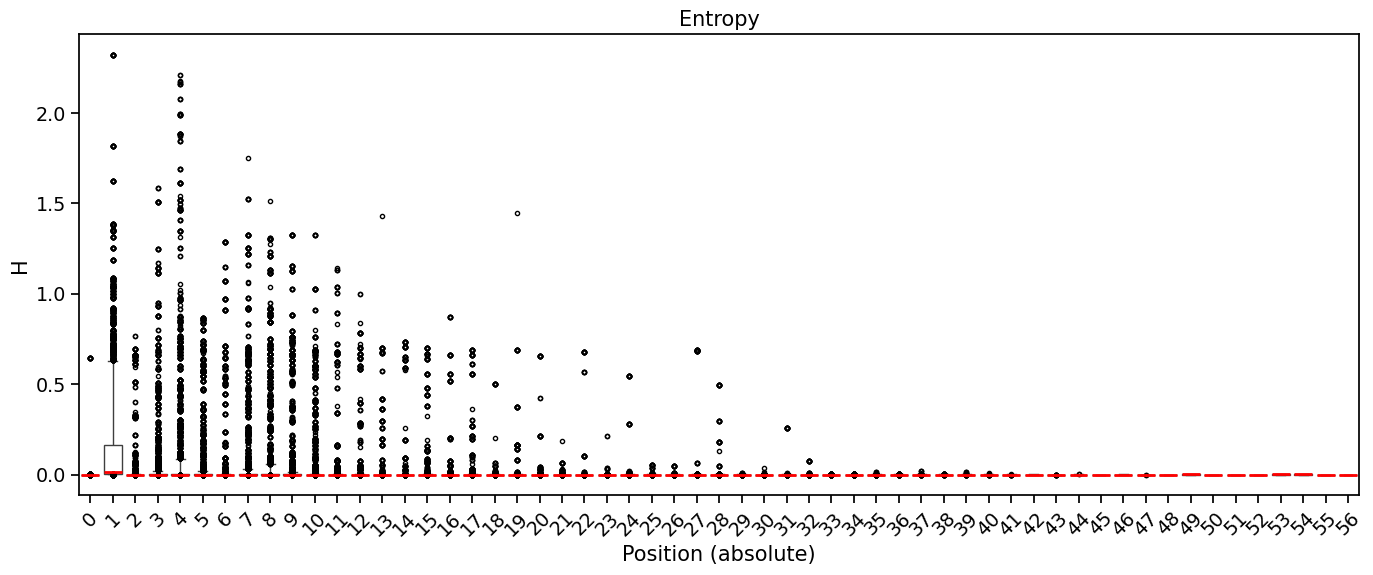

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

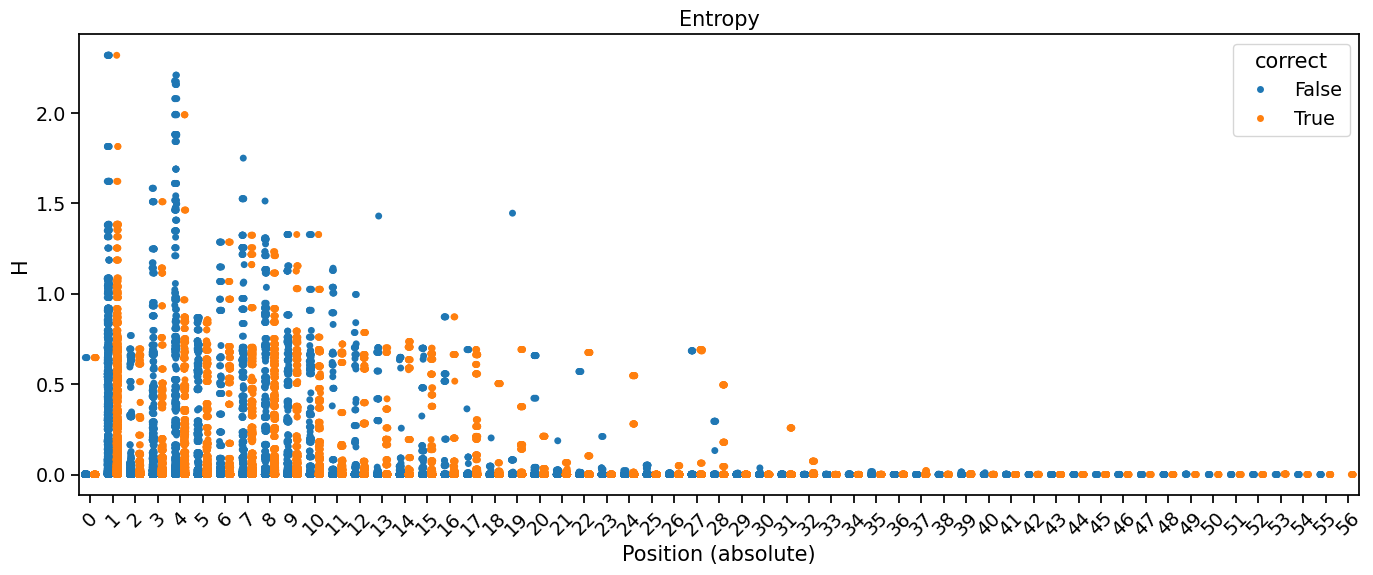

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [112]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [113]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [114]:
mm.shape

(22921191, 16)

In [115]:
m.shape

(2292100, 19)

In [116]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [117]:
# TODO: compare observables grouping by truth

In [118]:
# TODO: plot truth vs aggregated uncertainty